# **Pre-process Coronavirus Music Questionnaire (CMQ) data**
Lindsay Warrenburg & Lauren Fink  
lindsay.a.warrenburg@gmail.com  lauren.fink@ae.mpg.de  
Final version: December 20, 2020

The goal of this Jupyter Notebook is to conduct pre-processing, such as investigating where there might be missing data, removing any participants who were not taking the study seriously, and examining differences across participants in 6 countries (Germany, Italy, France, India, UK, and USA).

In [1]:
import numpy as np, math, pandas as pd, os, sys, scipy, xlrd, urllib, itertools, re, warnings, matplotlib.pyplot as plt, seaborn as sns
from pandas.api.types import CategoricalDtype
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)

# Local imports
import local_dicts # dictionary defining column labels for our dataframe and answer text~answer code relationships 
import local_funcs # functions that we might want to use in multiple scripts throughout the project
import importlib

importlib.reload(local_dicts) 
importlib.reload(local_funcs)

# display all columns in dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('raw_data.csv')
data.shape

(5907, 239)

# **Looking for Missing Values and Duplicates**

### Check the amount of overall missing values in the dataframe
Missing values make statistical models almost impossible to interpret. Even though we are not going to deal with them here, it's good to know what we are getting into.

In [3]:
null = data[data.isnull().any(axis=1)]
print(len(null),"participants with at least 1 missing value") 

5905 participants with at least 1 missing value


### Check that no rows have exactly the same observations (i.e., same participant, same answers)

In [4]:
print("are there duplicates? ", data.iloc[:,1:].duplicated().any())

are there duplicates?  False


### Exploring the Percent of Questions with Missing Values

We are not actually using this to screen people, but rather to understand better how people took the survey

In [5]:
# Count number of missing questions per person
data['Survey Info_Number of Missing Questions'] = data.isnull().sum(axis=1)

# find people who have more than 175 missing questions (out of of 202 total questions)
screenNaNs = data.loc[data['Survey Info_Number of Missing Questions'] > 175]
print(screenNaNs.shape[0], "participants with more than 175 questions incomplete.")

0 participants with more than 175 questions incomplete.


### Plot how many questions each participant is missing to see the general distribution.

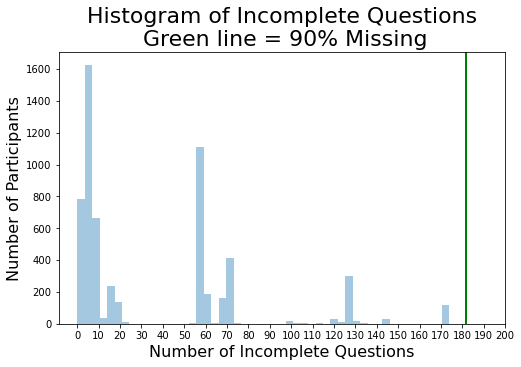

In [6]:
plt.figure(figsize=[8,5]);
ax = sns.distplot(data['Survey Info_Number of Missing Questions'], kde=False, bins = 50);
ax.axvline(x = 0.9*202, ymin = 0, ymax = 1, color = 'green', linewidth=2);
plt.title('Histogram of Incomplete Questions\n Green line = 90% Missing', size = 22);
plt.ylabel('Number of Participants', fontsize=16);
plt.xlabel('Number of Incomplete Questions', fontsize=16);
plt.xticks(np.arange(0, 210, step=10));

data = data.drop(['Survey Info_Number of Missing Questions'], axis=1)

# Screening Participants by Study Duration
Check who took too little time to complete the survey. Of course, there are some people who did not take the Music Listening/Making Music sections that we should keep. We only want to throw out people who took way too little time. We can check on those who took too long but we likely should not screen those who took too long, as participants could return to the survey at a later time. We also need to account for which sections of the survey they saw. 

### How many people did not answer any of the music listening/making questions? 
Our survey was based on skip logic. Namely, people were asked `Have you been (1) listening to music or (2) making music during the coronavirus crisis?` If they answered *Yes*, they were asked further questions about that activity (music listening or making). If they answered *No*, they did not see any questions about that activity (music listening or making).

In [7]:
# music listening
exclude_listening_list = ['Activities_Music Listening','Music Listening_Examples_Free Response','Music Listening_Functions_Free Response']
listening_list = [c for c in data.columns if 'Music Listening' in c and c not in exclude_listening_list]

data['tmp_listening'] = data[listening_list].isnull().apply(lambda x: all(x), axis=1)
print(data['tmp_listening'].sum(), "people did not answer any of the music listening questions")

491 people did not answer any of the music listening questions


In [8]:
# music making
exclude_performing_list = ['Activities_Making Music','Making Music_Examples_Free Response','Making Music_Functions_Free Response','Demographics_Music_Making Music-Alone','Demographics_Music_Making Music-Both Alone And Together','Demographics_Music_Making Music-Together','Demographics_Music_Making Music-No Response']
performing_list = [c for c in data.columns if 'Making Music' in c and c not in exclude_performing_list]

data['tmp_performing'] = data[performing_list].isnull().apply(lambda x: all(x), axis=1)
print(data['tmp_performing'].sum(), "people did not answer any of the music listening questions")

2343 people did not answer any of the music listening questions


### Create 4 groups with regards to the parts of the survey that they saw
- People who only took the *music listening* part of the survey
- People who only took the *music making* part of the survey
- People who took *both the music listening and music making* parts of the survey
- People who *did not take either the music listening or music making* parts of the survey (i.e., they only took the demographic/personality sections because they reported not listening to or making music during the coronavirus crisis)

In [9]:
# Creating the 4 groups
conditions = [(data.tmp_listening == True) & (data.tmp_performing == True), 
              (data.tmp_listening == False) & (data.tmp_performing == True),
              (data.tmp_listening == True) & (data.tmp_performing == False),
              (data.tmp_listening == False) & (data.tmp_performing == False)
             ]
choices = ['neither','listening only','performing only','both']

data["Survey Info_Group"] = np.select(conditions, choices, default=np.nan)

In [10]:
# Examine the average study duration for people in each of these 4 groups
data.groupby(['Survey Info_Group'])['Survey Info_Duration'].agg(['count','mean','std','min','max']).round(1)

,count,mean,std,min,max
Survey Info_Group,,,,,
both,3534,45.3,302.6,3.4,9041.7
listening only,1882,65.7,416.4,2.8,6967.6
neither,461,100.6,577.9,0.8,6171.9
performing only,30,18.5,15.2,7.7,74.9


### Exclude participants who took the shortest time to complete the survey, based on which sections of the survey (listening, making, both, neither) they saw

We elected to exclude the people in the lowest 10% of study duration for each group.

In [11]:
cut_percentile = 10

In [12]:
# People who did not see the music listening or music making sections
data['cut_len'] = np.nan
group1durs = data['Survey Info_Duration'].loc[data['Survey Info_Group'] == 'neither']
low10_g1 = np.percentile(group1durs, cut_percentile)
print('Neither music listening nor making:')
print('Lowest percentile under', low10_g1.round(1), 'minutes')
data['cut_len'] = np.where( (data['Survey Info_Group'] == 'neither') & (data['Survey Info_Duration'] <= low10_g1), 1, data['cut_len'])

Neither music listening nor making:
Lowest percentile under 2.6 minutes


In [13]:
# People who only saw the music listening questions
group2durs = data['Survey Info_Duration'].loc[data['Survey Info_Group'] == 'listening only']
low10_g2 = np.percentile(group2durs, cut_percentile)
print('Music listening only:')
print('Lowest percentile under', low10_g2.round(1), 'minutes')
data['cut_len'] = np.where( (data['Survey Info_Group'] == 'listening only') & (data['Survey Info_Duration'] <= low10_g2), 1, data['cut_len'])

Music listening only:
Lowest percentile under 8.4 minutes


In [14]:
# People who only saw the music making questions
group3durs = data['Survey Info_Duration'].loc[data['Survey Info_Group'] == 'performing only']
low10_g3 = np.percentile(group3durs, cut_percentile)
print('Music making only:')
print('Lowest percentile under', low10_g3.round(1), 'minutes')
data['cut_len'] = np.where( (data['Survey Info_Group'] == 'performing only') & (data['Survey Info_Duration'] <= low10_g3), 1, data['cut_len'])

Music making only:
Lowest percentile under 8.8 minutes


In [15]:
# People who saw both the music listening and music making questions
group4durs = data['Survey Info_Duration'].loc[data['Survey Info_Group'] == 'both']
low10_g4 = np.percentile(group4durs, cut_percentile)
print('Both music listening and music making:')
print('Lowest percentile under', low10_g4.round(1), 'minutes')
data['cut_len'] = np.where( (data['Survey Info_Group'] == 'both') & (data['Survey Info_Duration'] <= low10_g4), 1, data['cut_len'])

Both music listening and music making:
Lowest percentile under 8.5 minutes


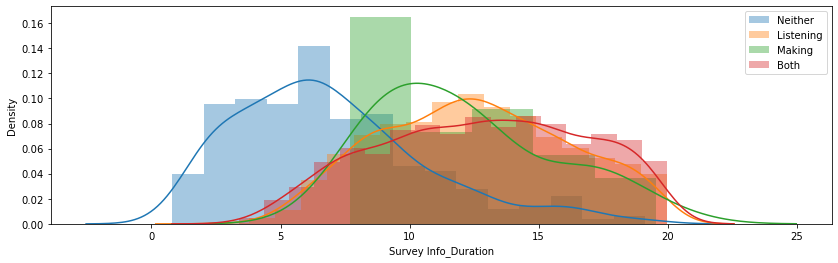

In [16]:
# graph
sns.distplot(group1durs[group1durs < 20], label = 'Neither')
sns.distplot(group2durs[group2durs < 20], label = 'Listening')
sns.distplot(group3durs[group3durs < 20], label = 'Making')
sns.distplot(group4durs[group4durs < 20], label = 'Both')
plt.legend()

### Exclude the participants we have flagged

In [17]:
print(data['cut_len'].sum(), 'participants were cut due to short study duration\n')
print(len(data),'original participants')

data = data[data['cut_len'] != 1]
print(len(data),'participants after duration exclusion')

data = data.drop(['cut_len','tmp_listening','tmp_performing'], axis=1)
data.reset_index(inplace = True, drop = True) 

595.0 participants were cut due to short study duration

5907 original participants
5312 participants after duration exclusion


# Screening Participants by Repeated Answers

This is our way of checking who answered all questions with the same response, while still taking into account (1) when this 0 variance is meaningful versus (2) when this 0 variance indicates lack of effort.

- Exclude participants who had 0 response range within each of the 3 sections (*Leisure Activities, Functions of Music Making, Functions of Music Listening*)
- **Exception:** Keep data if the repeated response was `4: No change from before the pandemic to during the pandemic`

In [18]:
# leisure activities
activities = [col for col in data.columns if col.startswith('Activities_')]

act_zero_std = (np.nanstd(data[activities],axis=1) == 0) 
act_not_same_as_before = data[activities].apply(lambda x: ~x.isin([4.,0.,99.,np.nan])).sum(axis=1) > 0
cut_activities_ids = data[act_zero_std & act_not_same_as_before].ID.unique().tolist()
print(len(cut_activities_ids), "participants excluded for 0 variance in the activities section")

31 participants excluded for 0 variance in the activities section


In [19]:
# functions of music listening
listening = [col for col in data.columns if col.startswith('Music Listening_Functions') and col != 'Music Listening_Functions_Free Response']

list_zero_std = (np.nanstd(data[listening],axis=1) == 0) 
list_not_same_as_before = data[listening].apply(lambda x: ~x.isin([4.,0.,99.,np.nan])).sum(axis=1) > 0
cut_listening_ids = data[list_zero_std & list_not_same_as_before].ID.unique().tolist()
print(len(cut_listening_ids), "participants excluded for 0 variance in the music listening section")

156 participants excluded for 0 variance in the music listening section


In [20]:
# functions of music making
playing = [col for col in data.columns if col.startswith('Making Music_Functions') and col != 'Making Music_Functions_Free Response']

play_zero_std = (np.nanstd(data[playing],axis=1) == 0) 
play_not_same_as_before = data[playing].apply(lambda x: ~x.isin([4.,0.,99.,np.nan])).sum(axis=1) > 0
cut_playing_ids = data[play_zero_std & play_not_same_as_before].ID.unique().tolist()
print(len(cut_playing_ids), "participants excluded for 0 variance in the making music section")

104 participants excluded for 0 variance in the making music section


In [21]:
# total
cut_all = [cut_activities_ids, cut_listening_ids, cut_playing_ids]
drop_ids = set.intersection(*map(set,cut_all))
print(len(drop_ids), "participants who were flagged for exclusion in all 3 categories")

cut_ids = list(set([y for x in cut_all for y in x]))
cut_ids.sort()

print(len(cut_ids),"total participants excluded due to 0 response variance")

18 participants who were flagged for exclusion in all 3 categories
199 total participants excluded due to 0 response variance


### Exclude the participants we have flagged

In [22]:
data = data[~data.ID.isin(cut_ids)]
data.reset_index(inplace = True, drop = True)
print(len(data),'participants after 0 variance exclusion')

5113 participants after 0 variance exclusion


# Overall Data Investigation

Now that we've screened out participants, let's look at some information about the data. 

### Number of participants by country

In [23]:
data.groupby(['Country_Country Name']).size()

Country_Country Name
France     983
Germany    872
India      891
Italy      892
UK         621
USA        854
dtype: int64

### Study duration

In [24]:
print(data['Survey Info_Duration'].agg(['min','max','mean','median','std']).round(1))
data = data.drop(['Survey Info_Duration'], axis=1)

min          2.6
max       9041.7
mean        63.1
median      17.0
std        396.3
Name: Survey Info_Duration, dtype: float64


### Percent missing and median value by column

In [25]:
df = data[data.columns.difference(['ID'])]
checking = df.describe(percentiles=[0.5]).T
checking['percent missing'] = (((len(df) - checking['count'])/len(df))*100).round(2)
checking = checking.loc[checking['percent missing'] >0,['percent missing','50%']].sort_values(['percent missing'], ascending=False)
#checking

# Recoding

We need to do a little bit of cleaning before we can use the data in other scripts.

### Create binary gender column because of lack of representative data for people who did not answer 'woman' or 'man'

In [26]:
# 0 = woman, 1 = man
data['Demographics_General_Gender_binary'] = data['Demographics_General_Gender'].astype(str)
data = data.replace({'Demographics_General_Gender_binary': {'1.0': 0, '2.0': 1, '3.0': np.nan, '4.0': np.nan, 'nan': np.nan}})

### Recode values from Qualtrics
- `99` in Qualtrics referred to an unanswered question --> recode as `NaN`
- `0` in Qualtrics referred to a response of `never do this/does not apply` --> recode as `4: no change before and during the coronavirus crisis`

In [27]:
recoding_cols = [col for col in data.columns if 'Activities_' in col or '_Hypotheses_' in col 
                 or '_Functions_' in col or '_Situations_' in col 
                 or 'Music Listening_Formats_' in col] + ['Music Engagement_Diversity of Music', 'Music Engagement_Interest in Others Music', 'Music Engagement_Nostalgic Music']

data[recoding_cols] = data[recoding_cols].replace({99:np.nan, 0:4.})

### High Correlations

In [28]:
# correlations
cor_real = data.corr()
cor_abs = data.corr().abs()
triangle = cor_real.where(np.triu(np.ones(cor_real.shape), k = 1).astype(np.bool))

cor = cor_abs.unstack()
cor = cor.sort_values(kind="quicksort", ascending = False)
cor = pd.DataFrame(cor)
cor.columns = ['cor']
cor = cor.query('cor < 1')

cor_high = cor.query('0.90 < cor < 1')
print("{:.2f}".format((len(cor_high)/len(cor))*100), "% of correlations > 0.90")
print("Highest (absolute value) correlation is", "{:.2f}".format(cor['cor'].max()))

0.01 % of correlations > 0.90
Highest (absolute value) correlation is 0.94


In [29]:
# highest correlations
cor_high

cor
Country_Confirmed Deaths          Country_Confirmed Cases            0.940590
Country_Confirmed Cases           Country_Confirmed Deaths           0.940590
Country_Stringency Index          Country_Government Response Index  0.925485
Country_Government Response Index Country_Stringency Index           0.925485
                                  Country_Containment Health Index   0.925350
Country_Containment Health Index  Country_Government Response Index  0.925350

# Export data

### Export Text Responses
Make a new dataframe (and export CSV file) of the free responses and then remove them from the quantitative data frame.

In [30]:
# create new dataframe of free text responses
demo = ['Country_Country Name', 'Demographics_General_Age', 'Demographics_General_Gender', 'Demographics_Music_Ollen']
free = [col for col in data.columns if col.endswith('Free Response')]

cleanedTextCols = ['ESM_ID'] + demo + free
free_responses = data[cleanedTextCols]

In [31]:
# map column values to something meaningful so that those working with it outside of coding environment don't need to look up values
free_responses['Demographics_General_Gender'] = free_responses['Demographics_General_Gender'].map(local_dicts.answer_code_dict['Demographics_General_Gender'])
free_responses['Demographics_Music_Ollen'] = free_responses['Demographics_Music_Ollen'].map(local_dicts.answer_code_dict['Demographics_Music_Ollen'])

In [32]:
# export in csv and xls formats
free_responses.to_csv(r'free_responses.csv', index = None, header = True)
free_responses.to_excel(r'free_responses.xls', index = None, header = True)

### Export Quantitative Data
This is the data table LW and LF will use in all the analyses for the manuscript.

In [33]:
# remove free response columns in the quantitative dataframe
data = data.drop(['Demographics_COVID_Living Situation Free Response',
                  'Making Music_Examples_Free Response', 
                  'Making Music_Functions_Free Response', 
                  'Music Engagement_Other Ways Use Music Differently Free Response',
                  'Music Listening_Examples_Free Response',
                  'Music Listening_Functions_Free Response'], 
                 axis=1)

In [34]:
data.shape

(5113, 234)

In [35]:
data.to_csv(r'cleaned_data.csv', index = None, header = True)